In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
import torch
from torch.utils.data import Dataset
import json
import numpy as np
from torch.serialization import add_safe_globals
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#MODEL_DIR = "snips_intent_model_fewshot/snips_intent_model_70" #Can change to 10, 20, 50, 70 or 100 model.

MODEL_DIR = "snips_intent_model_full" #For full model

c:\Users\Pradhyumnaa G\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.eval()

with open("label2id.json") as f:
    label2id = json.load(f)
with open("id2label.json") as f:
    id2label = json.load(f)

id2label = {int(k): v for k, v in id2label.items()}

In [3]:
class SnipsDataset(Dataset):
    def __init__(self, df_or_encodings):
        if isinstance(df_or_encodings, dict):
            self.encodings = df_or_encodings["encodings"]
            self.labels = df_or_encodings["labels"]
        else:
            self.encodings = df_or_encodings
            self.labels = df_or_encodings['labels']

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [4]:
# Add class definition so torch.load can unpickle

from __main__ import SnipsDataset 
add_safe_globals([SnipsDataset])

test_dataset = torch.load("dataset/snips_test_dataset.pt", weights_only=False)

In [5]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {
        "accuracy": acc,
        "f1": f1
    }

In [6]:
trainer = Trainer(
    model=model,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [7]:
results = trainer.evaluate(eval_dataset=test_dataset)
results

{'eval_loss': 0.09892396628856659,
 'eval_model_preparation_time': 0.002,
 'eval_accuracy': 0.9856527977044476,
 'eval_f1': 0.9857648540181932,
 'eval_runtime': 1.5085,
 'eval_samples_per_second': 462.058,
 'eval_steps_per_second': 58.337}

In [8]:
preds = trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=-1)

In [9]:
target_names = [id2label[i] for i in range(len(id2label))]

print(classification_report(y_true, y_pred, target_names=target_names))

                      precision    recall  f1-score   support

       AddToPlaylist       0.99      1.00      1.00       100
      BookRestaurant       1.00      1.00      1.00       100
          GetWeather       1.00      0.99      0.99        99
           PlayMusic       1.00      0.97      0.98       100
            RateBook       1.00      1.00      1.00        98
  SearchCreativeWork       0.92      1.00      0.96       100
SearchScreeningEvent       1.00      0.94      0.97       100

            accuracy                           0.99       697
           macro avg       0.99      0.99      0.99       697
        weighted avg       0.99      0.99      0.99       697



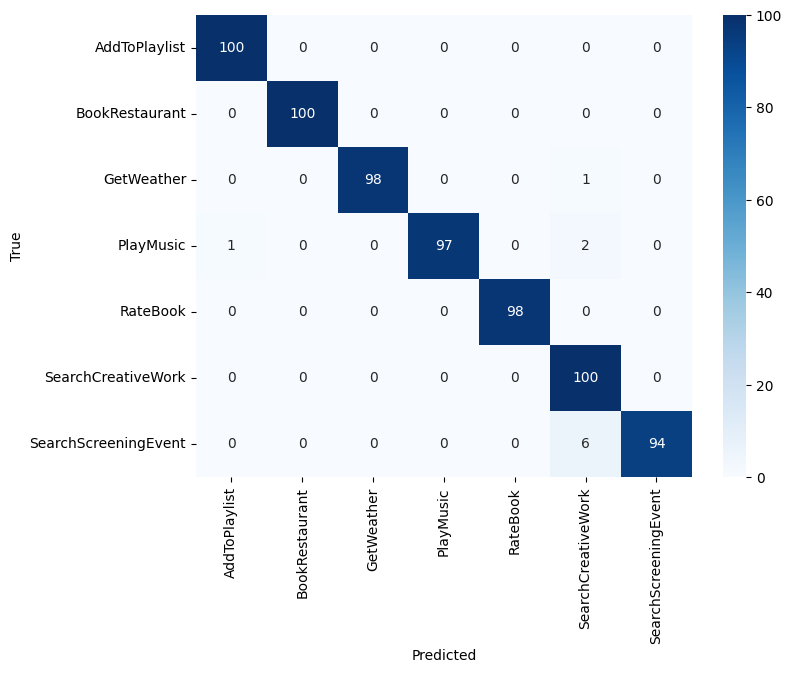

In [10]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [11]:
wrong = (y_true != y_pred).nonzero()[0]
len(wrong)

for idx in wrong:
    sample = test_dataset[idx]
    text = tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
    true_label = id2label[int(sample['labels'])]
    pred_label = id2label[int(y_pred[idx])]
    
    print("Text:", text)
    print("True:", true_label)
    print("Pred:", pred_label)
    print("---")

Text: where is belgium located
True: GetWeather
Pred: SearchCreativeWork
---
Text: play all things must pass.
True: PlayMusic
Pred: SearchCreativeWork
---
Text: live in l. a joseph meyer please
True: PlayMusic
Pred: SearchCreativeWork
---
Text: put what color is your sky by alana davis on the stereo.
True: PlayMusic
Pred: AddToPlaylist
---
Text: i want to see jla adventures : trapped in time
True: SearchScreeningEvent
Pred: SearchCreativeWork
---
Text: where can i see the prime ministers : the pioneers
True: SearchScreeningEvent
Pred: SearchCreativeWork
---
Text: i want to see medal for the general
True: SearchScreeningEvent
Pred: SearchCreativeWork
---
Text: i want to see fear chamber.
True: SearchScreeningEvent
Pred: SearchCreativeWork
---
Text: i want to see shattered image.
True: SearchScreeningEvent
Pred: SearchCreativeWork
---
Text: i want to see outcast.
True: SearchScreeningEvent
Pred: SearchCreativeWork
---
